In [220]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [221]:
import numpy as np
import scipy as sp
import json
import torch
torch.set_default_dtype(torch.float64)
device="cpu"

from rascaline import SphericalExpansion, SphericalExpansionByPair
from equistore import Labels, TensorBlock, TensorMap
from equistore import operations

from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.mp_utils import acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix, flatten
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import hamiltonian_features
import matplotlib.pyplot as plt

import copy
from utils.model_hamiltonian import *
from itertools import product
import tqdm.notebook as tqdm
import chemiscope

In [222]:
from generate_bispectrum_structures import generate_nu3_degen_structs

# Generates a bunch of degenerate pairs - closer or farther from being actually symmetric

In [322]:
frames = []
n1, n2, n3 = 8,8,8
for psi in np.linspace(np.pi/6, np.pi*5/6, n1):
    for dphi1 in np.linspace(np.pi*2/3 - 1.2, np.pi*2/3+0.4, n2):
        for dphi2 in np.linspace(np.pi*2/3-0.7, np.pi*2/3+1.3, n3):
            frames += generate_nu3_degen_structs(2, [0, dphi1, dphi1+dphi2], 
                           psi, 1, np.sqrt(5), "Mg", "Mg", "Mg")

In [323]:
# shuffles keeping pairs together for easier analysis
idx = np.asarray(range(len(frames)//2), dtype=int)
np.random.shuffle(idx)
nfr = []
for i in idx:
    nfr.append(frames[2*i])
    nfr.append(frames[2*i+1])
frames = nfr

In [324]:
cs = chemiscope.show(frames=frames, mode="structure", settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

StructureWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": t…

# Compute raw expansion coefficients

In [325]:
hypers = {
    "cutoff": 3.5,
    "max_radial": 2,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 0.0,    
}
calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames)
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)

# selects only one environment
rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
for b in rho1i.blocks():
    b.values[:]/=norm_rho1

/home/michele/local/lib/python3.8/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


In [326]:
rho1i

TensorMap with 4 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center']
           1             1                    0                  12
           1             1                    1                  12
           1             1                    2                  12
           1             1                    3                  12

In [327]:
rho1i.block(0)

TensorBlock
    samples: ['structure', 'center']
    component: ['spherical_harmonics_m']
    properties: ['species_neighbor_1', 'n_1']
    gradients: no

In [328]:
calculator = SphericalExpansionByPair(**hypers)
gij = calculator.compute(frames)
gij = operations.slice(gij, samples=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)
for b in gij.blocks():
    b.values[:]/=norm_rho1

In [329]:
gij

TensorMap with 4 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center' 'species_neighbor']
           1             1                    0                  12               12
           1             1                    1                  12               12
           1             1                    2                  12               12
           1             1                    3                  12               12

In [330]:
gij.block(0)

TensorBlock
    samples: ['structure', 'center', 'neighbor']
    component: ['spherical_harmonics_m']
    properties: ['n_1']
    gradients: no

## Test there is consistency at the level of rhoij and gij

In [331]:
test = operations.sum_over_samples(gij, sample_names=["structure", "center"]) 

In [332]:
test.block(1).values;

In [333]:
np.linalg.norm(rho1i.block(1).values/test.block(1).values -1)

2.8459135300545673e-13

# Now compute the correlation stuff!

In [334]:
cg = ClebschGordanReal(5)

## pair features

In [335]:
%%time
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)

CPU times: user 6.99 s, sys: 1.08 s, total: 8.08 s
Wall time: 12.9 s


In [336]:
%%time 
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0, filter_sigma=[1])

CPU times: user 4.65 s, sys: 656 ms, total: 5.3 s
Wall time: 6.18 s


### sanity checks

In [337]:
# nb: we disable lexicographic sorting of L to have comparable feature layout
rho2i_full = cg_combine(rho1i, rho1i, clebsch_gordan=cg, lcut=3, sorted_l=False)
test = operations.sum_over_samples(rhoii1i2_nu0, sample_names=["structure", "center"]) 

In [338]:
np.linalg.norm(rho2i_full.block(2).values/test.block(2).values-1)

1.1257237471483063e-11

## higher-order 

In [339]:
# here we use all tricks to reduce cost
rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=3)
rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=3)
rho4i = cg_increment(rho3i, rho1i, clebsch_gordan=cg, lcut=3)
rho5i = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=0, filter_sigma=[1])

Since we have a LOT of features and few structures, we use PCA to reduce the number of features with no information loss

In [340]:
from sklearn.decomposition import PCA

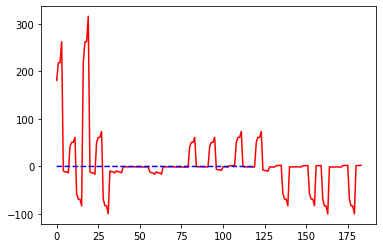

In [341]:
plt.plot(rhoii1i2_nu1.block(0).values.squeeze()[:64].sum(axis=0)*2e3,'r-')
plt.plot(rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()[0], 'b--')

In [342]:
triplet_samples = rhoii1i2_nu1.block(0).samples
raw = rhoii1i2_nu1.block(0).values.squeeze()
feats_n2nu1 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw))
feats_n2nu1 /= np.sqrt((feats_n2nu1**2).sum(axis=1).mean())

In [343]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu123 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

In [344]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho4i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho5i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu12345 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

tensor(277)


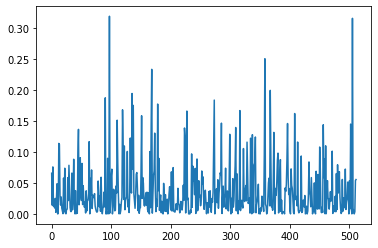

In [345]:
plt.plot(np.sqrt(((feats_nu12345[::2]-feats_nu12345[1::2])**2).sum(axis=1))/np.sqrt(((feats_nu12345[::2]+feats_nu12345[1::2])**2).sum(axis=1)) )
print(np.sqrt(((feats_nu12345[::2]-feats_nu12345[1::2])**2).sum(axis=1)).argmax())

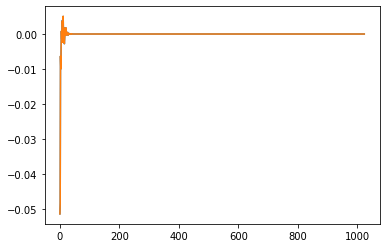

In [346]:
plt.plot(feats_nu12345[14])
plt.plot(feats_nu12345[15])

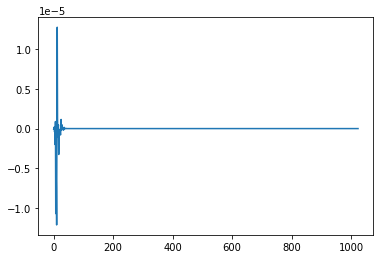

In [347]:
plt.plot(feats_nu12345[20]-feats_nu12345[21])

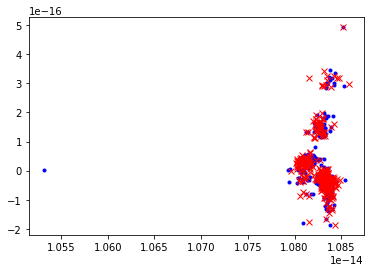

In [348]:
plt.plot(feats_nu123[::2,7], feats_nu123[::2,8], 'b.')
plt.plot(feats_nu123[1::2,7], feats_nu123[1::2,8], 'rx')

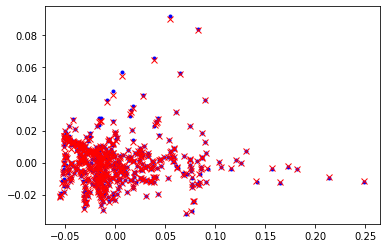

In [349]:
plt.plot(feats_nu12345[::2,2], feats_nu12345[::2,3], 'b.')
plt.plot(feats_nu12345[1::2,2], feats_nu12345[1::2,3], 'rx')

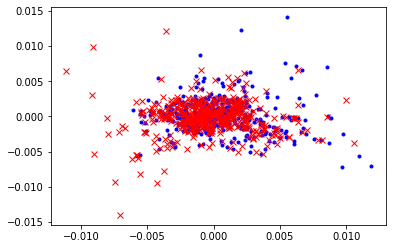

In [350]:
plt.plot(feats_nu12345[::2,12], feats_nu12345[::2,13], 'b.')
plt.plot(feats_nu12345[1::2,12], feats_nu12345[1::2,13], 'rx')

# Now we make an autoencoder thingie

In [312]:
def StructureMap(samples_structure, device="cpu"):
    unique_structures, unique_structures_idx = np.unique(
        samples_structure, return_index=True
    )
    new_samples = samples_structure[np.sort(unique_structures_idx)]
    # we need a list keeping track of where each atomic contribution goes
    # (e.g. if structure ids are [3,3,3,1,1,1,6,6,6] that will be stored as
    # the unique structures [3, 1, 6], structure_map will be
    # [0,0,0,1,1,1,2,2,2]
    replace_rule = dict(zip(unique_structures, range(len(unique_structures))))
    structure_map = torch.tensor(
        [replace_rule[i] for i in samples_structure],
        dtype=torch.long,
        device=device,
    )
    return structure_map, new_samples, replace_rule

In [313]:
class EncodeDecodeLinear(torch.nn.Module):
    def __init__(self, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.feat_size = feat_size
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(
            torch.nn.Linear(X.shape[-1], self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.output_size),            
        )
    
    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, "cpu"
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [314]:
class EncodeDecode(torch.nn.Module):
    def __init__(self, layer_size=100, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.feat_size = feat_size
        self.layer_size = layer_size        
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(
            
            torch.nn.Linear(X.shape[-1], self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.output_size),            
        )

    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, "cpu"
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [351]:
feats_nu12345.shape

torch.Size([1024, 1024])

In [352]:
target = feats_nu12345[:,:128]

In [353]:
mymodel = EncodeDecodeLinear(32, target.shape[-1])

In [354]:
mymodel = EncodeDecode(64, 32, target.shape[-1])

In [355]:
mymodel.initialize_model_weights(feats_n2nu1, seed=12345)

In [356]:
def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten()) ** 2)

In [357]:
optimizer = torch.optim.LBFGS(
        mymodel.parameters(),
        lr=0.1,
        line_search_fn="strong_wolfe",
        history_size=128,
    )

In [ ]:
n_epochs = 500
ntrain = 512
ntriples = 64
for epoch in range(0, n_epochs):
    if epoch%4==0:
        print("Beginning epoch", epoch)
    
    def single_step():
        # global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        
        predicted = mymodel(feats_n2nu1[:ntrain*ntriples], triplet_samples["structure"][:ntrain*ntriples])
        loss += loss_mse(predicted, target[:ntrain])
        
        loss.backward(retain_graph=False)
        return loss

    loss = optimizer.step(single_step)
    predicted = mymodel(feats_n2nu1[ntrain*ntriples:], triplet_samples["structure"][ntrain*ntriples:])
    
    if epoch % 4 ==0:
        print("Energy RMSE: train ", np.sqrt(loss.detach().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, target[ntrain:]).detach().numpy().flatten()[0]/ (len(frames)-ntrain)) )

Beginning epoch 0
Energy RMSE: train  0.020311563803113202 test 0.020590143866459874
Beginning epoch 4
Energy RMSE: train  0.020180741381018188 test 0.02044249267346043
Beginning epoch 8
Energy RMSE: train  0.020055410132042525 test 0.020284508327134503
Beginning epoch 12
Energy RMSE: train  0.019931315528908568 test 0.020021836065771143
Beginning epoch 16
Energy RMSE: train  0.019843269790566647 test 0.019929335900932148
Beginning epoch 20
Energy RMSE: train  0.019754467809405044 test 0.019853935886008423
Beginning epoch 24


In [371]:
predicted = mymodel(feats_n2nu1, triplet_samples["structure"])
feats = mymodel.feats(feats_n2nu1, triplet_samples["structure"])

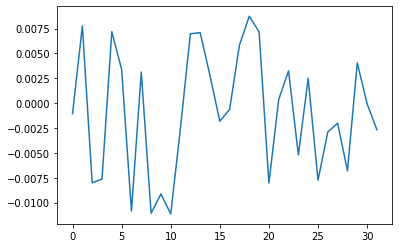

In [372]:
plt.plot(feats[30].detach()-feats[31].detach())

tensor(277)


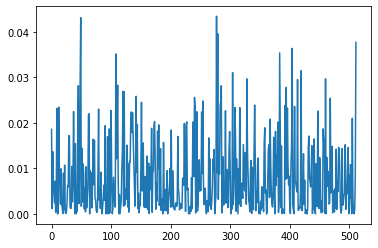

In [373]:
plt.plot(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1)))
print(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1)).argmax())

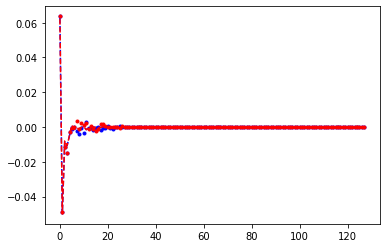

In [374]:
iframe = 130
plt.plot(predicted[iframe].detach(),'b--')
plt.plot(target[iframe].detach(),'b.')
plt.plot(predicted[iframe+1].detach(), 'r--')
plt.plot(target[iframe+1].detach(), 'r.')

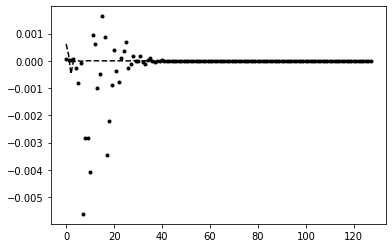

In [375]:
plt.plot((predicted[iframe].detach()-predicted[iframe+1].detach()),'k--')
plt.plot(target[iframe].detach()-target[iframe+1].detach(), 'k.')

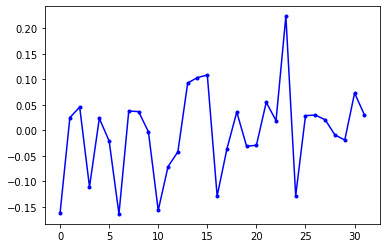

In [217]:
plt.plot((feats[iframe].detach()-feats[iframe+1].detach()),'b.-')